<a href="https://colab.research.google.com/github/ucheetah/exoplanet-viz-cluster/blob/main/NASA_exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NASA Exoplanet Data Analysis**

This notebook covers:

*   Initial settings and style parameters
*   Collecting and cleaning the Planetary Systems data
*   Missing value analysis and outlier handling
*   Planet radius - graphs
*   Distance from Earth - graphs

## **Initial settings and style parameters**

Imports

In [1]:
import requests
import math
import pandas as pd
import numpy as np
from scipy import constants
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler
import seaborn as sns
import seaborn.objects as so
import missingno as msno

Upload drive

In [2]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


I've imported a matplotlib stylesheet that I've personalized on the [dark_background](https://matplotlib.org/stable/gallery/style_sheets/dark_background.html) stylesheet:


In [3]:
matplotlib.style.use('/content/gdrive/MyDrive/exoplanet_dark_background.mplstyle')

Bad key figure.format in file /content/gdrive/MyDrive/exoplanet_dark_background.mplstyle, line 7 ('figure.format: svg')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


We can define a color palette that we'll use throughout:

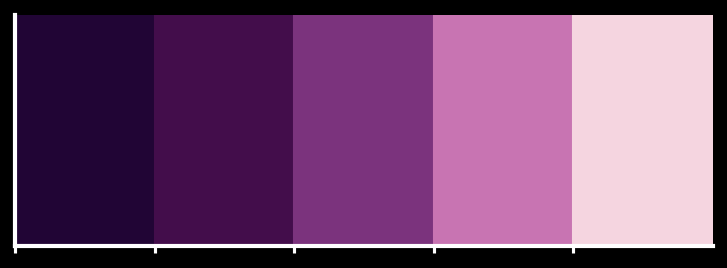

In [4]:
# Define color palette
color_palette = ["#210535", "#430d4b", "#7b337d", "#c874b2", "#f5d5e0"]

# Display the colors
fig, ax = plt.subplots(figsize=(6, 2))

for idx, color in enumerate(color_palette):
    ax.add_patch(plt.Rectangle((idx, 0), 1, 1, color=color))

ax.set_xlim(0, len(color_palette))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(color_palette)))
ax.set_xticklabels([])
ax.set_yticks([])

fig.dpi = 150
plt.show()

## **Collecting and cleaning NASA exoplanet data**

We're grabbing data from [NASA exoplanets archive](https://exoplanetarchive.ipac.caltech.edu/index.html). The archive is a collaboration between the California Institute of Technology (Caltech) and NASA under the Exoplanet Exploration Program. We are drawing from the **Planetary Systems** dataset, which provides in depth data on every confirmed exoplanet known to astronomists to date. The Table contains one row per planet per reference and collects data such as its radius and mass, distance, stellar systems.

For many values such as mass and radius, the tables does include uncertainty columns, but I won't be concerned with them within the scope of this project. To be kept in mind that values can have confidence intervals of sizes of hundreds of units.


#### **Choosing varables of interest**

From the [parameter table documentation](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html) for this dataset I chose a small set of values from the dataset that are likely to be of biggest immediate interest:

*   `pl_name`: Planet name
*   `sy_dist`: Distance [pc] (Distance to the planetary system in units of parsecs)
*   `sy_snum `: Number of Stars (in the planetary system)
*   `sy_pnum`: Number of Planets (in the planetary system)
*   `disc_year`: Discovery Year
*   `pl_rade`: Planet Radius [Earth Radius]
*   `pl_masse`: Planet Mass [Earth Mass]
*   `st_teff`: Stellar Effective Temperature [K]
*   `st_rad`: Stellar Radius [Solar Radius]



#### **Querying the data**

To query this data we generate the industry standard **Table Access Protocol (TAP)** which uses **AQDL (Astronomical Query Data Language)** - akin to SQL for astronomical databases - to write queries.

*   Use Python's `requests` package to access NASA data using TAP protocol. I've written a short SQL (technically AQDL) queries which paired with `requests` grabs these columns:

```
          SELECT pl_name, sy_dist, sy_snum, sy_pnum, disc_year, pl_rade,pl_masse,st_teff, st_rad
          FROM ps
```
To fit it into a [TAP protocol](https://exoplanetarchive.ipac.caltech.edu/docs/TAP/usingTAP.html) we simply need to make a few adjustments such as remove additional spacing, add `+` between the major SQL statements. Full procedure:

*   Write data as a CSV into MyDrive.
*   Call CSV into notebook.

In [5]:
request_csv = requests.get("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,sy_dist,sy_snum,sy_pnum,disc_year,pl_rade,pl_masse,st_teff,st_rad+from+ps&format=csv")

with open('/content/gdrive/MyDrive/exoplanet_data.csv', 'w') as f:
    f.write(request_csv.text)

Call CSV into notebook

In [6]:
exoplanet_data = pd.read_csv('/content/gdrive/MyDrive/exoplanet_data.csv')

#### **Exploratory data analysis**

Now that we've obtained our data can perform some preliminary EDA on it:

In [7]:
exoplanet_data.head()

,pl_name,sy_dist,sy_snum,sy_pnum,disc_year,pl_rade,pl_masse,st_teff,st_rad
0,OGLE-TR-10 b,1344.9700,1,1,2004,14.011,197.046,5950.00,1.17
1,BD-08 2823 b,41.3342,1,2,2009,NaN,NaN,4746.00,NaN
2,BD-08 2823 c,41.3342,1,2,2009,NaN,NaN,4746.00,NaN
3,HR 8799 c,41.2441,1,4,2008,13.000,3000.000,NaN,NaN
4,HD 104985 b,100.5760,1,1,2003,NaN,NaN,4679.37,11.63


The dataset has 35,964 entries and the 8 columns we called.

In [8]:
exoplanet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35964 entries, 0 to 35963
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pl_name    35964 non-null  object 
 1   sy_dist    35133 non-null  float64
 2   sy_snum    35964 non-null  int64  
 3   sy_pnum    35964 non-null  int64  
 4   disc_year  35964 non-null  int64  
 5   pl_rade    24449 non-null  float64
 6   pl_masse   3707 non-null   float64
 7   st_teff    33081 non-null  float64
 8   st_rad     33110 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 2.5+ MB


Using describe we can note that there appear to be some significant discrepancies in `count`; missing values could provide more context.

In [9]:
exoplanet_data.describe()

,sy_dist,sy_snum,sy_pnum,disc_year,pl_rade,pl_masse,st_teff,st_rad
count,35133.000000,35964.000000,35964.000000,35964.000000,24449.000000,3707.000000,33081.000000,33110.000000
mean,732.518348,1.085530,1.884551,2015.320237,5.287643,746.773064,5465.072012,1.154935
std,787.354452,0.309859,1.205548,3.815719,69.927688,1557.642794,1007.618494,1.841809
min,1.301190,1.000000,1.000000,1992.000000,0.270000,0.020000,415.000000,0.010000
25%,297.462000,1.000000,1.000000,2014.000000,1.550000,15.200000,5098.000000,0.790000
50%,601.629000,1.000000,1.000000,2016.000000,2.280000,187.201870,5613.000000,0.950000
75%,945.775000,1.000000,2.000000,2016.000000,3.226000,635.643405,5953.000000,1.210000
max,8800.000000,4.000000,8.000000,2024.000000,4282.980000,25426.400000,57000.000000,88.470000


#### **Column renaming and cleaning**

We can make a few adjustments to the data. We can replace columns and delete duplicate entries:

In [10]:
exoplanets = exoplanet_data.rename(
    columns = {
      "pl_name": "Planet name",
      "sy_dist": "Distance [pc]",
      "sy_snum": "Number of Stars",
      "sy_pnum": "Number of Planets",
      "disc_year": "Discovery Year",
      "pl_rade": "Planet Radius [Earth Radius]",
      "pl_masse": "Planet Mass [Earth Mass]",
      "st_teff": "Stellar Effective Temperature [K]",
      "st_rad": "Stellar Radius [Solar Radius]"
    })

exoplanets = exoplanets.drop_duplicates(subset=['Planet name']).reset_index(drop=True)

We notice now that our table has been significantly reduced in size (from 35k to 5k) without duplicates.

In [11]:
exoplanets

,Planet name,Distance [pc],Number of Stars,Number of Planets,Discovery Year,Planet Radius [Earth Radius],Planet Mass [Earth Mass],Stellar Effective Temperature [K],Stellar Radius [Solar Radius]
0,OGLE-TR-10 b,1344.9700,1,1,2004,14.011,197.04600,5950.00,1.17
1,BD-08 2823 b,41.3342,1,2,2009,NaN,NaN,4746.00,NaN
2,BD-08 2823 c,41.3342,1,2,2009,NaN,NaN,4746.00,NaN
3,HR 8799 c,41.2441,1,4,2008,13.000,3000.00000,NaN,NaN
4,HD 104985 b,100.5760,1,1,2003,NaN,NaN,4679.37,11.63
...,...,...,...,...,...,...,...,...,...
5625,K2-368 d,206.6080,1,3,2022,1.948,NaN,4663.00,0.66
5626,TOI-532 b,135.0470,1,1,2021,5.820,61.50000,3927.00,0.61
5627,KMT-2017-BLG-2509L b,7040.0000,1,1,2021,NaN,664.26137,NaN,NaN
5628,OGLE-2017-BLG-1099L b,7250.0000,1,1,2021,NaN,959.84179,NaN,NaN


## **Missing value analysis and outlier handling**

I directed some attention to missing values and outliers to better understand the data.

### **Graph - Columns missing values**

We can learn about our dataset by tracking missing values.

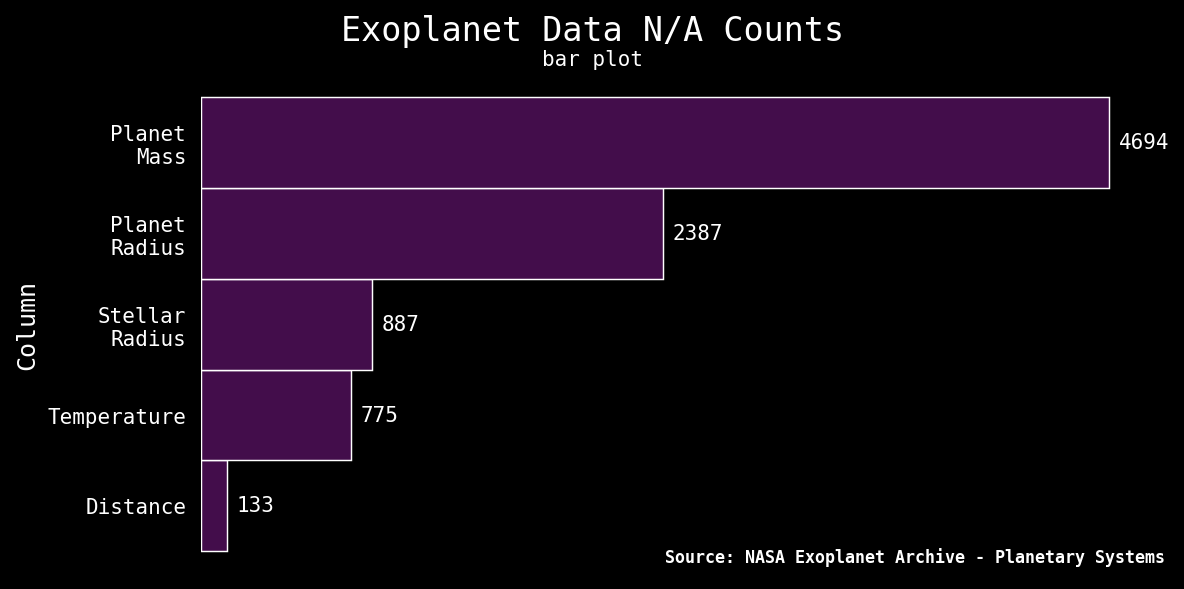

In [12]:
nullsums = exoplanets.isnull().sum()
nullsums = nullsums[nullsums > 0].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

fig.suptitle("Exoplanet Data N/A Counts", size=16, y=0.97)
fig.text(0.5, 0.885, "bar plot", ha='center', fontsize=10)
fig.text(0.56, 0.05, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom', fontsize=8, fontweight='bold')
fig.dpi = 150

bar_height = 0.01
spacing = 0
positions = [i * (bar_height + spacing) for i in range(len(nullsums))]
ax.set_yticks(positions)

bars = ax.barh(positions, nullsums.values, color=color_palette[1], edgecolor="white", height=bar_height, linewidth=0.7)

for bar, position in zip(bars, positions):
    width = bar.get_width()
    ax.text(width + 50, position, f'{int(width)}', va='center', ha='left', color='white')

# Axes
ax.set_ylabel("Column")
ax.set_yticks([i * (bar_height + spacing) for i in range(len(nullsums))])
ax.set_yticklabels(['Distance', 'Temperature', 'Stellar\nRadius', 'Planet\nRadius', 'Planet\nMass'], ha='right')

# Ticks
for spine in ax.spines.values():
    spine.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])

plt.tight_layout()
plt.show()

### **Graph - Known vs. unknown radius [Histogram]**

Adding a missing radius column.

In [13]:
exoplanets['Missing Radius'] = exoplanets['Planet Radius [Earth Radius]'].isnull()
known_radius_mass = exoplanets[exoplanets['Missing Radius'] == False]['Planet Mass [Earth Mass]']
unknown_radius_mass = exoplanets[exoplanets['Missing Radius'] == True]['Planet Mass [Earth Mass]']


Plotting histograms

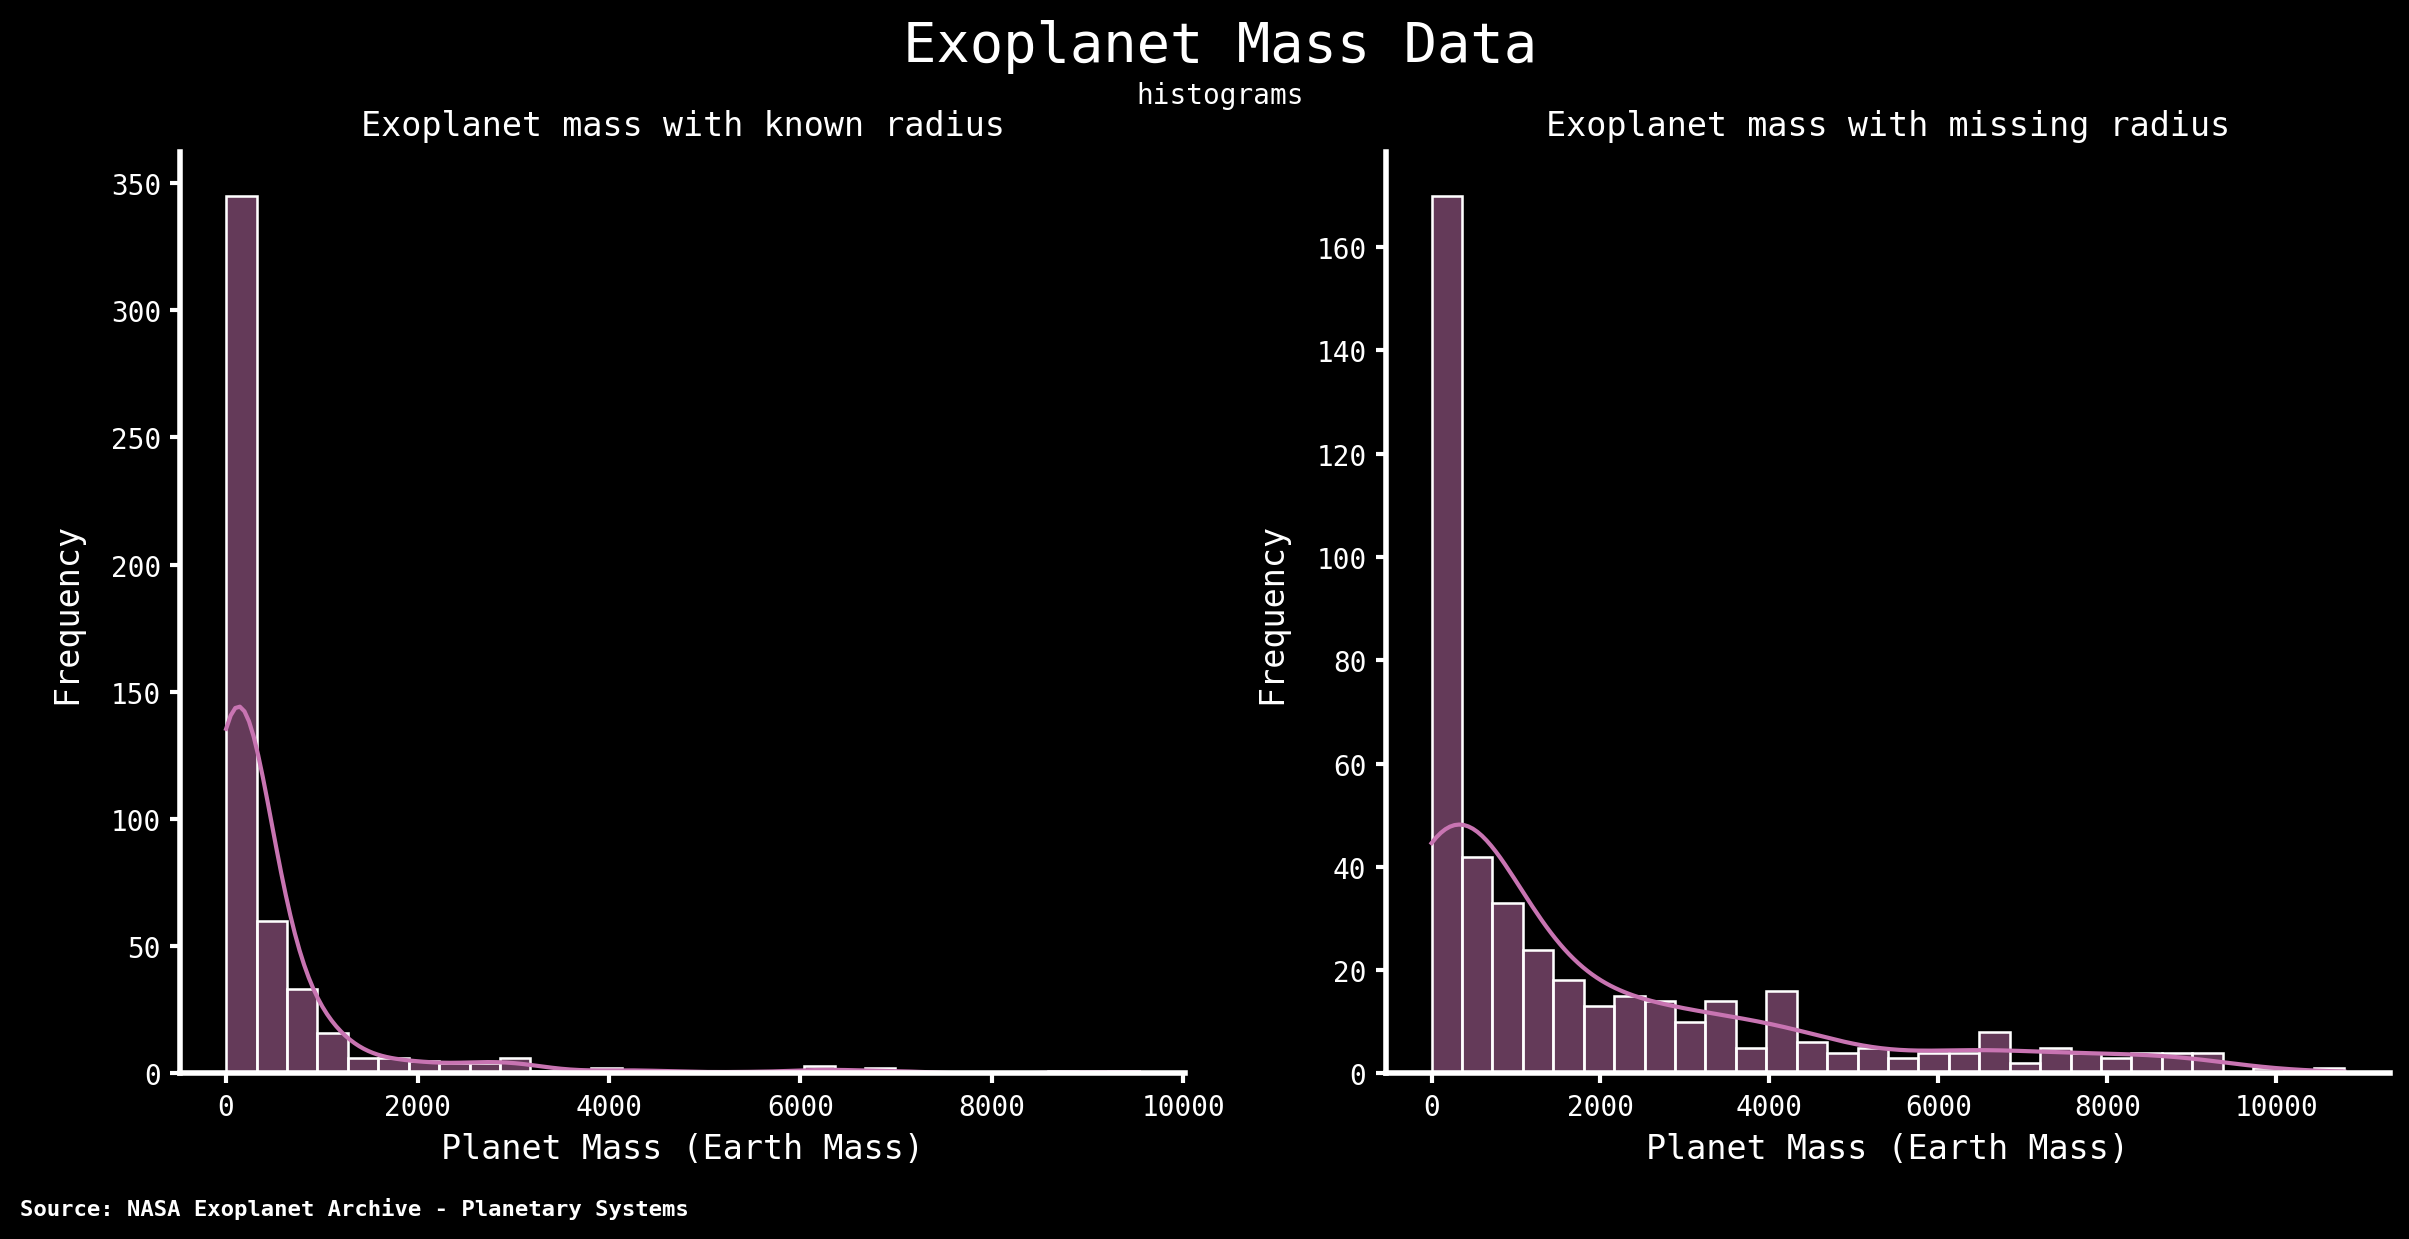

In [19]:
fig = plt.figure(figsize=(12, 6), dpi=200)

fig.suptitle("Exoplanet Mass Data", fontsize = 20)
fig.text(0.5, 0.91, "histograms", ha='center', fontsize=10)
fig.text(0, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')

# Histogram - Known radius
plt.subplot(1, 2, 1)
sns.histplot(known_radius_mass, bins=30, color="#c874b2", kde=True, orientation ='horizontal')
plt.title('Exoplanet mass with known radius', size = 12)
plt.xlabel('Planet Mass (Earth Mass)')
plt.ylabel('Frequency', labelpad = 10)

# Histogram - Unknown radius
plt.subplot(1, 2, 2)
sns.histplot(unknown_radius_mass, bins=30, color="#c874b2", orientation ='horizontal', kde=True)
plt.title('Exoplanet mass with missing radius', size = 12)
plt.xlabel('Planet Mass (Earth Mass)')
plt.ylabel('Frequency', labelpad = 10)

plt.tight_layout()
plt.show();

### **Outlier handling**

We can take a look at outliers.

#### **Radius outliers**

Looking at the percentiles we notice that only above the 90th percentile does the radius seem to shoot upwards.

In [15]:
exoplanets['Planet Radius [Earth Radius]'].describe(percentiles = [0, .01, .025, .05, .1, .2, .3, .4, .5, .6,.7,.8,.9,1])

count    3243.000000
mean        6.309451
std        86.739066
min         0.310000
0%          0.310000
1%          0.710000
2.5%        0.830000
5%          0.983700
10%         1.170000
20%         1.430000
30%         1.700000
40%         2.010000
50%         2.330000
60%         2.651200
70%         3.110000
80%         4.939600
90%        12.060800
100%     3791.050000
max      3791.050000
Name: Planet Radius [Earth Radius], dtype: float64

As we can see by tracking the largest radii (>50x Earth radius) we see five major values, some of which seem excessively large.

In [17]:
exoplanets[(exoplanets['Planet Radius [Earth Radius]'] > 50)].sort_values(by="Planet Radius [Earth Radius]", ascending = False).loc[:,['Planet name', 'Planet Radius [Earth Radius]']]

,Planet name,Planet Radius [Earth Radius]
4219,Kepler-230 b,3791.050
2447,Kepler-1946 b,3163.540
1324,Kepler-444 f,90.810
1063,HD 100546 b,77.342
1322,Kepler-444 d,69.820


Quickly referencing NASA's pages on these exoplanets we determine discrepancies in these values.

*   **Kepler-230 b** - 4.25x Earth radius; not 3791x - [Kepler-230 b](https://science.nasa.gov/exoplanet-catalog/kepler-230-b/)
*   **Kepler-1946 b** - 2.49x Earth Radius ; not 3791x - [Kepler-1946 b NASA](https://science.nasa.gov/exoplanet-catalog/kepler-1946-b/)
*   **Kepler-444 f** - 0.741 x Earth radius; not 90x - [Kepler-444 f](https://science.nasa.gov/exoplanet-catalog/kepler-444-f/)
*   **HD 100546** - 77.34x Earth radius; accurate - [HD 100546](https://science.nasa.gov/exoplanet-catalog/hd-100546-b/)
*   **Kepler-444 d** - 0.53x Earth radius; not 69.8x - [Kepler-444 d](https://science.nasa.gov/exoplanet-catalog/kepler-444-d/)

We replace the four rows showing discrepancies with their real values:

In [22]:
exoplanets.loc[exoplanets['Planet name'] == 'Kepler-230 b', 'Planet Radius [Earth Radius]'] = 4.25
exoplanets.loc[exoplanets['Planet name'] == 'Kepler-1946 b', 'Planet Radius [Earth Radius]'] = 2.49
exoplanets.loc[exoplanets['Planet name'] == 'Kepler-444 f', 'Planet Radius [Earth Radius]'] = 0.741
exoplanets.loc[exoplanets['Planet name'] == 'HD 100546', 'Planet Radius [Earth Radius]'] = 77.34
exoplanets.loc[exoplanets['Planet name'] == 'Kepler-444 d', 'Planet Radius [Earth Radius]'] = 0.53

Looking at the table once more our results are more sensible. HD 100546 b	is by many sources listed as the exoplanet with the biggest known radius.

In [60]:
exoplanets.sort_values(by="Planet Radius [Earth Radius]", ascending = False)

,Planet name,Distance [pc],Number of Stars,Number of Planets,Discovery Year,Planet Radius [Earth Radius],Planet Mass [Earth Mass],Stellar Effective Temperature [K],Stellar Radius [Solar Radius],Missing Mass,Missing Radius
1063,HD 100546 b,109.677,1,1,2014,77.342,2701.54146,10500.0,NaN,False,False
4257,Kepler-57 c,644.140,1,2,2012,45.650,NaN,5324.0,0.79,True,False
569,HAT-P-54 b,143.651,1,1,2015,40.000,NaN,4441.0,0.68,True,False
4273,Kepler-141 c,301.183,1,2,2014,37.400,NaN,4104.0,19.20,True,False
5029,Kepler-359 d,1443.210,1,3,2014,34.820,NaN,6090.0,1.19,True,False
...,...,...,...,...,...,...,...,...,...,...,...
5615,EPIC 212587672 c,320.070,1,2,2016,NaN,NaN,6055.0,0.95,True,True
5620,MOA-2010-BLG-328L b,810.000,1,1,2013,NaN,9.20000,NaN,NaN,False,True
5627,KMT-2017-BLG-2509L b,7040.000,1,1,2021,NaN,664.26137,NaN,NaN,False,True
5628,OGLE-2017-BLG-1099L b,7250.000,1,1,2021,NaN,959.84179,NaN,NaN,False,True


## **Planet Radius**

### **Evaluating exoplanet radius and mass**

Simple scatterplot comparing radius and mass. We notice that actually the semi-log/lin-log plot comparing mass and radius generates a linear like. General positive correlation.

There is a higher density of planets with radii between 1 and 10 Earth radii and masses between 1 and 100 Earth masses.

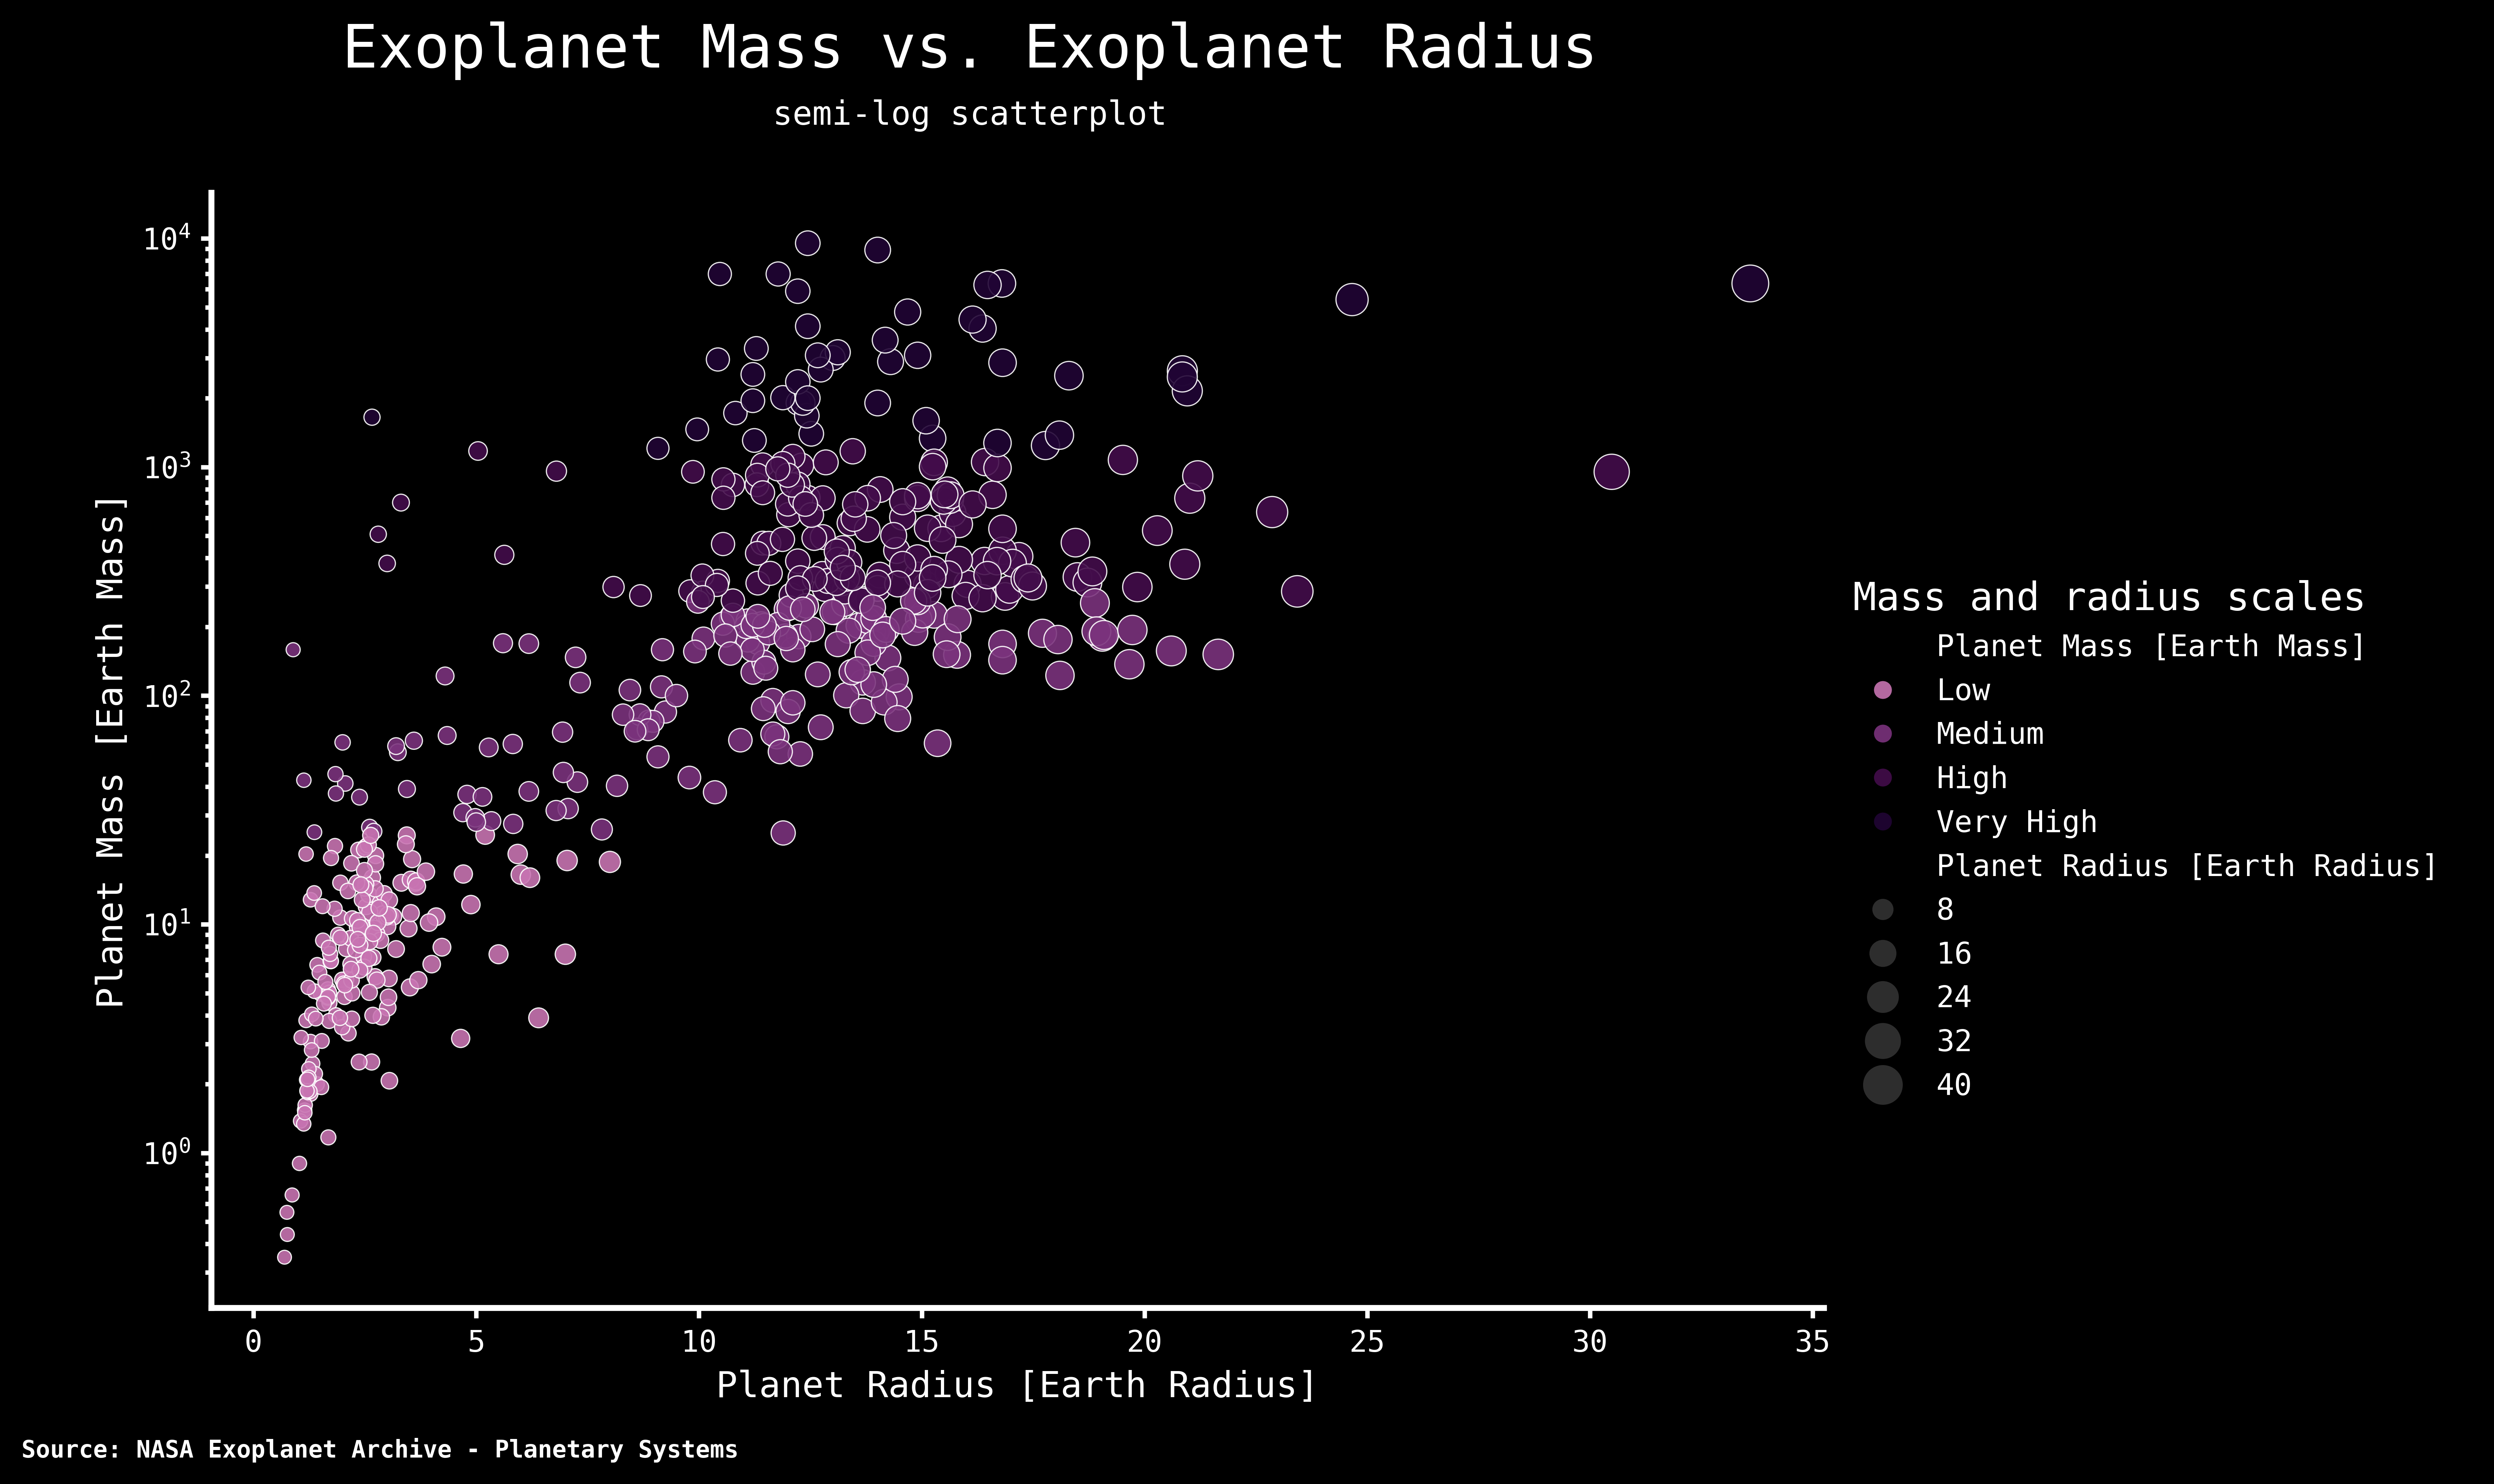

In [23]:
exoplanets_radius = exoplanets[exoplanets['Planet Radius [Earth Radius]'] != exoplanets['Planet Radius [Earth Radius]'].max()]
mass_bins = pd.qcut(exoplanets_radius['Planet Mass [Earth Mass]'], q=4, labels=["Low", "Medium", "High", "Very High"])

# Scatter
scatter = sns.relplot(
            data=exoplanets_radius,
            x="Planet Radius [Earth Radius]",
            y="Planet Mass [Earth Mass]",
            hue=mass_bins,
            size="Planet Radius [Earth Radius]",
            palette=["#c874b2", "#7b337d","#430d4b", "#210535"],
            sizes=(20, 200),
            kind='scatter',
            legend="brief",
            height=6,
            aspect=1,
            alpha=0.9
        )

# Figure
scatter.fig.tight_layout()
scatter.fig.subplots_adjust(right=.95)
scatter.fig.suptitle('Exoplanet Mass vs. Exoplanet Radius', fontsize=20, y=1.1)
scatter.fig.text(0.5, 1.02,"semi-log scatterplot", ha="center", fontsize=11)
scatter.fig.text(0, -0.02, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')
scatter.dpi = 600

# Axes
for ax in scatter.axes.flat:
    ax.set_yscale('log')
    ax.grid(False)
scatter.set_axis_labels('Planet Radius [Earth Radius]', 'Planet Mass [Earth Mass]')


# Legend
scatter._legend.set_title("Mass and radius scales", prop={'size': 13})
scatter._legend._legend_box.align = "left"
scatter._legend.set_bbox_to_anchor((1.30, 0.5))

plt.show()

## **Distance from Earth**

### **Graph: Distance from Earth [Histogram]**

We next track exoplanet distance from Earth. Unsurprisingly, the number of known exoplanets taper off with distance; limitations in measurement.

<ipython-input-63-ed2d17c2b034>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=ticks)


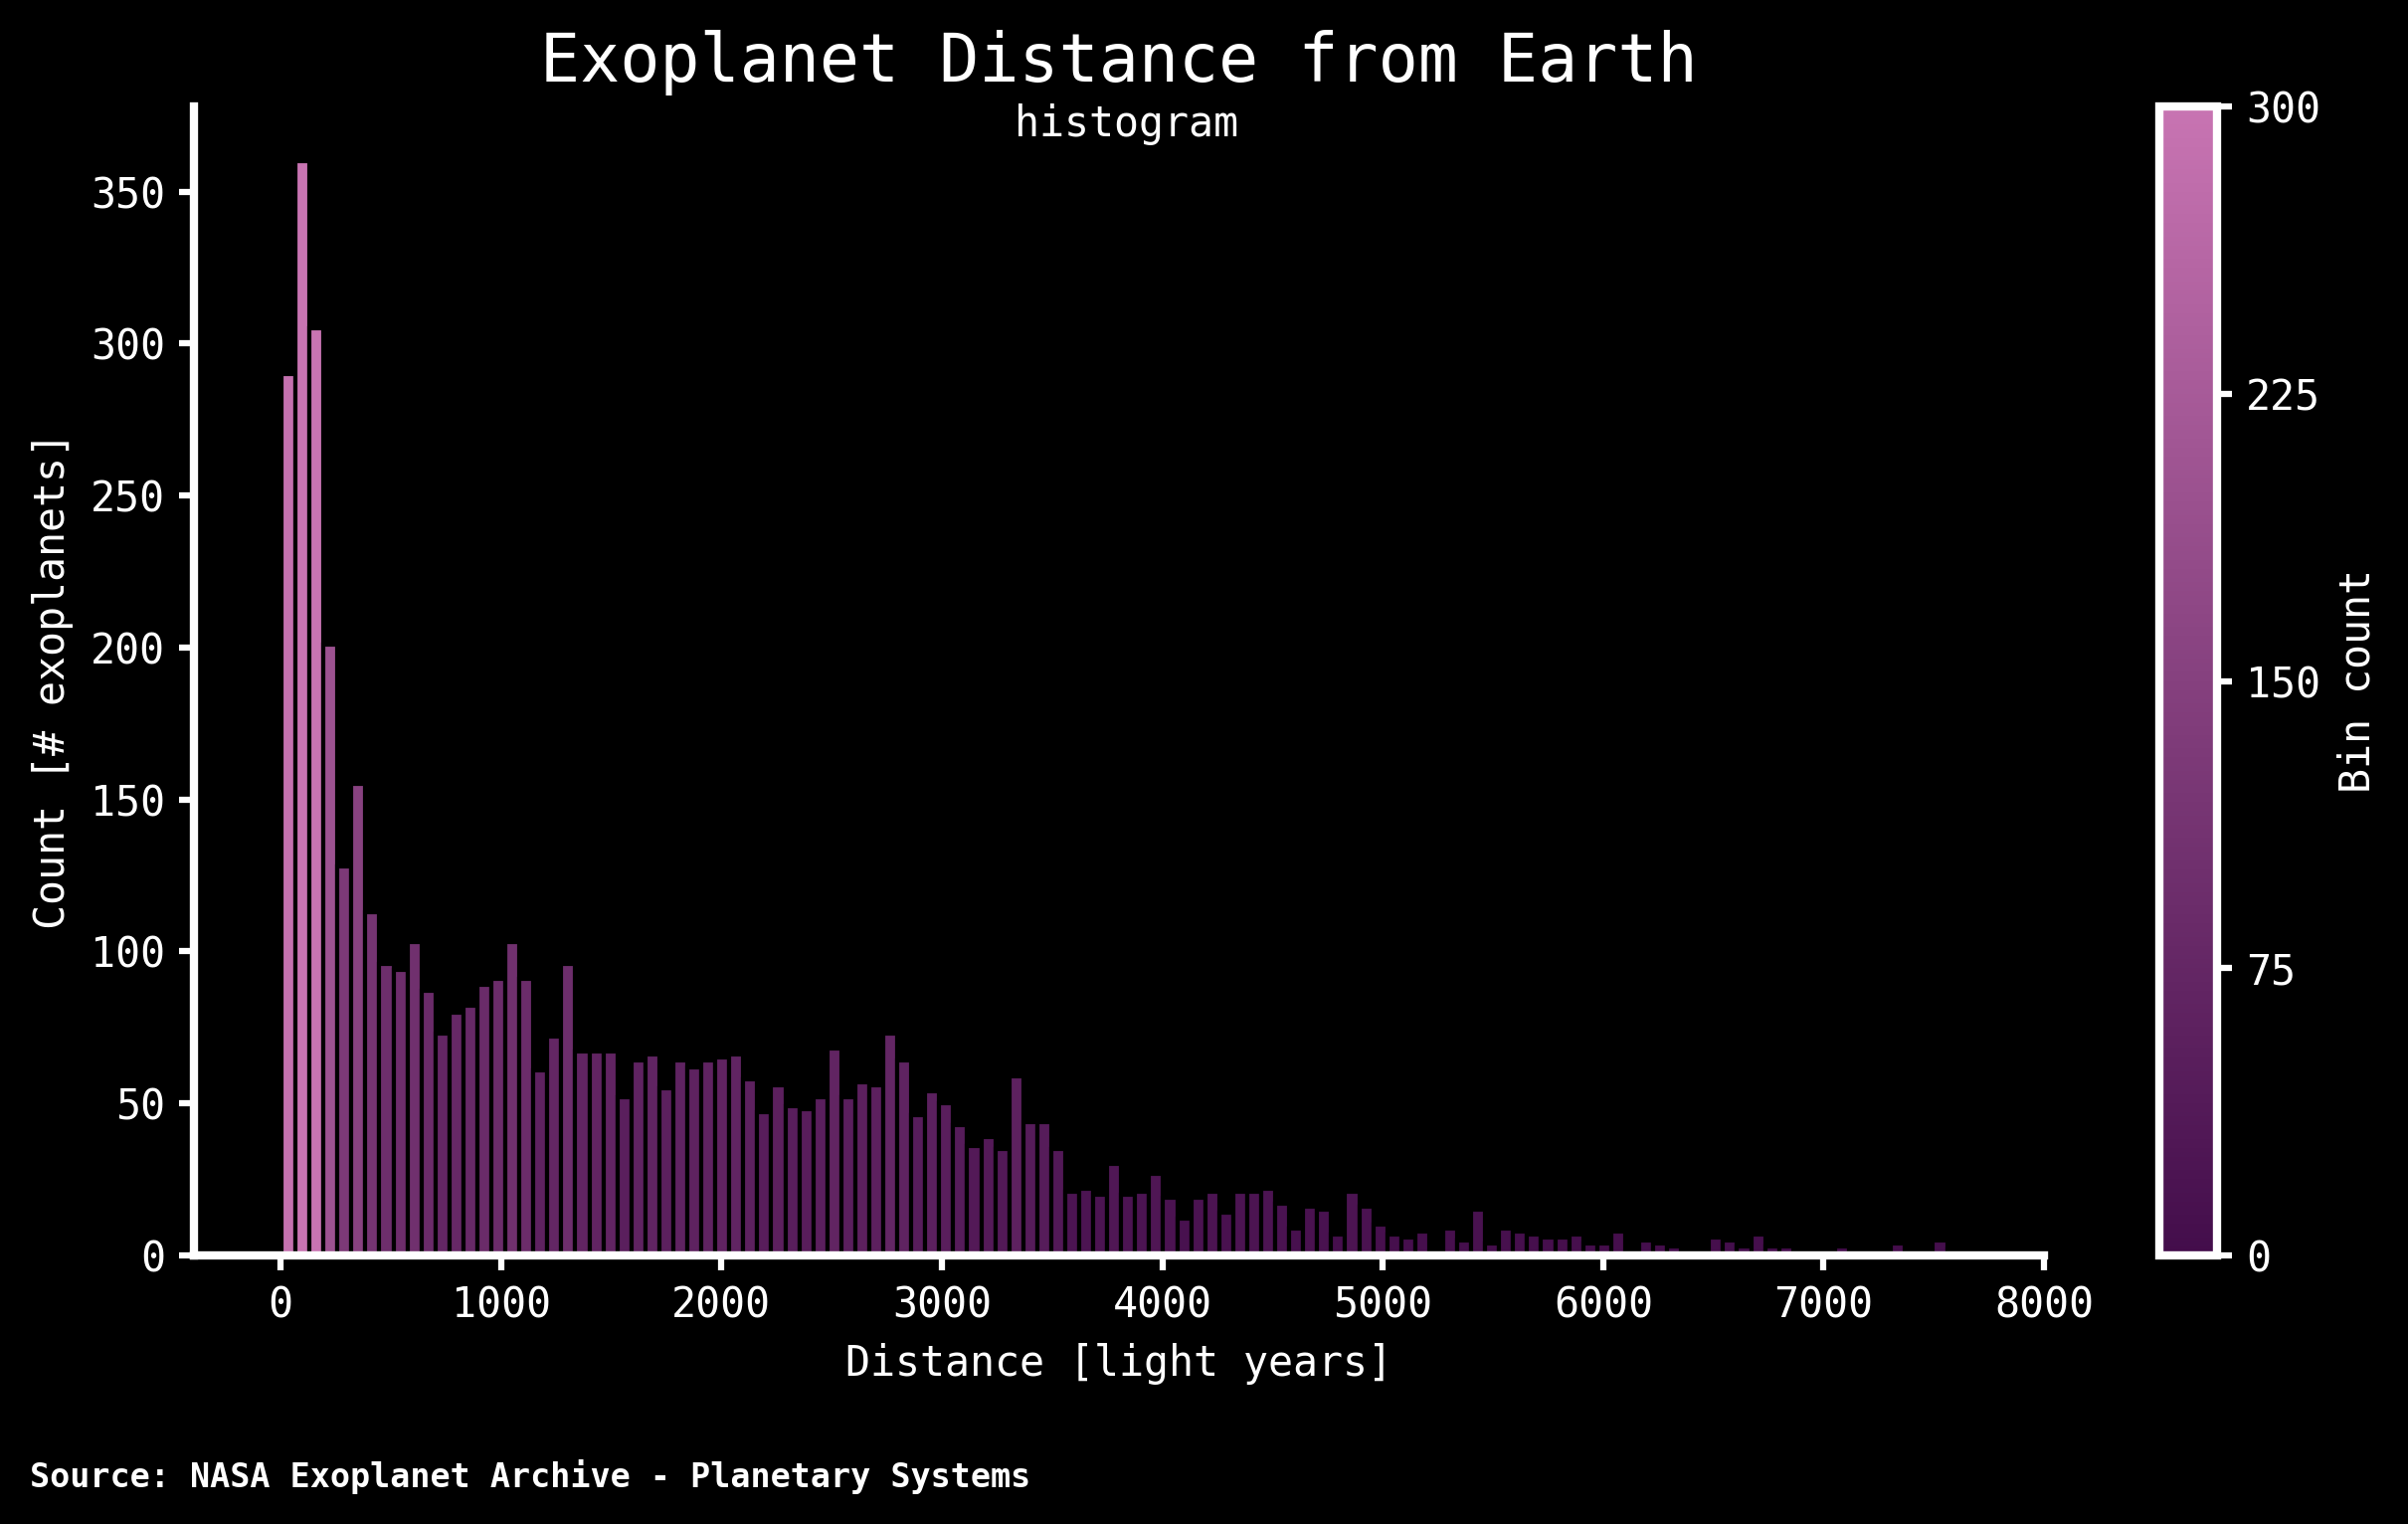

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))

fig.dpi = 300

# Histogram computation

filtered_distances = exoplanets[exoplanets['Distance [pc]'] * 3.26 < 8000]
counts, bins, patches = ax.hist(filtered_distances['Distance [pc]'] * 3.26, bins=125, edgecolor='black')
cmap = LinearSegmentedColormap.from_list("my_gradient", ["#430d4b", "#C874B2"])
norm = plt.Normalize(counts.min(), 300)

# Axis

ax.set_xlabel('Distance [light years]', fontsize = 10)
ax.set_xlim(right = 8000)
ax.set_ylabel('Count [# exoplanets]', fontsize = 10)
ax.set_aspect('auto')
ax.grid(False)
ax.set_title('Exoplanet Distance from Earth', fontsize = 16)
fig.text(0.4, 0.86,"histogram", fontsize=10)

fig.text(0.07, -0.05, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')

# Color

for count, bin, patch in zip(counts, bins, patches):
    color = cmap(norm(count))
    patch.set_facecolor(color)

# Colorbar and ticks

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = [0, 75, 150, 225, 300]
cbar = plt.colorbar(sm, ticks=ticks)
cbar.set_label('Bin count', fontsize=10)

# Spines

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.show();

### **Graph: Distance from Earth [CDF]**

Plotting a CDF of exolanet distance from Earth. Notice that close to 90% of known exoplanets are within the ten thousand light year range.

<ipython-input-356-14fbfa41e6ca>:24: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, which='minor', linestyle='-', linewidth=0.25, color='w')


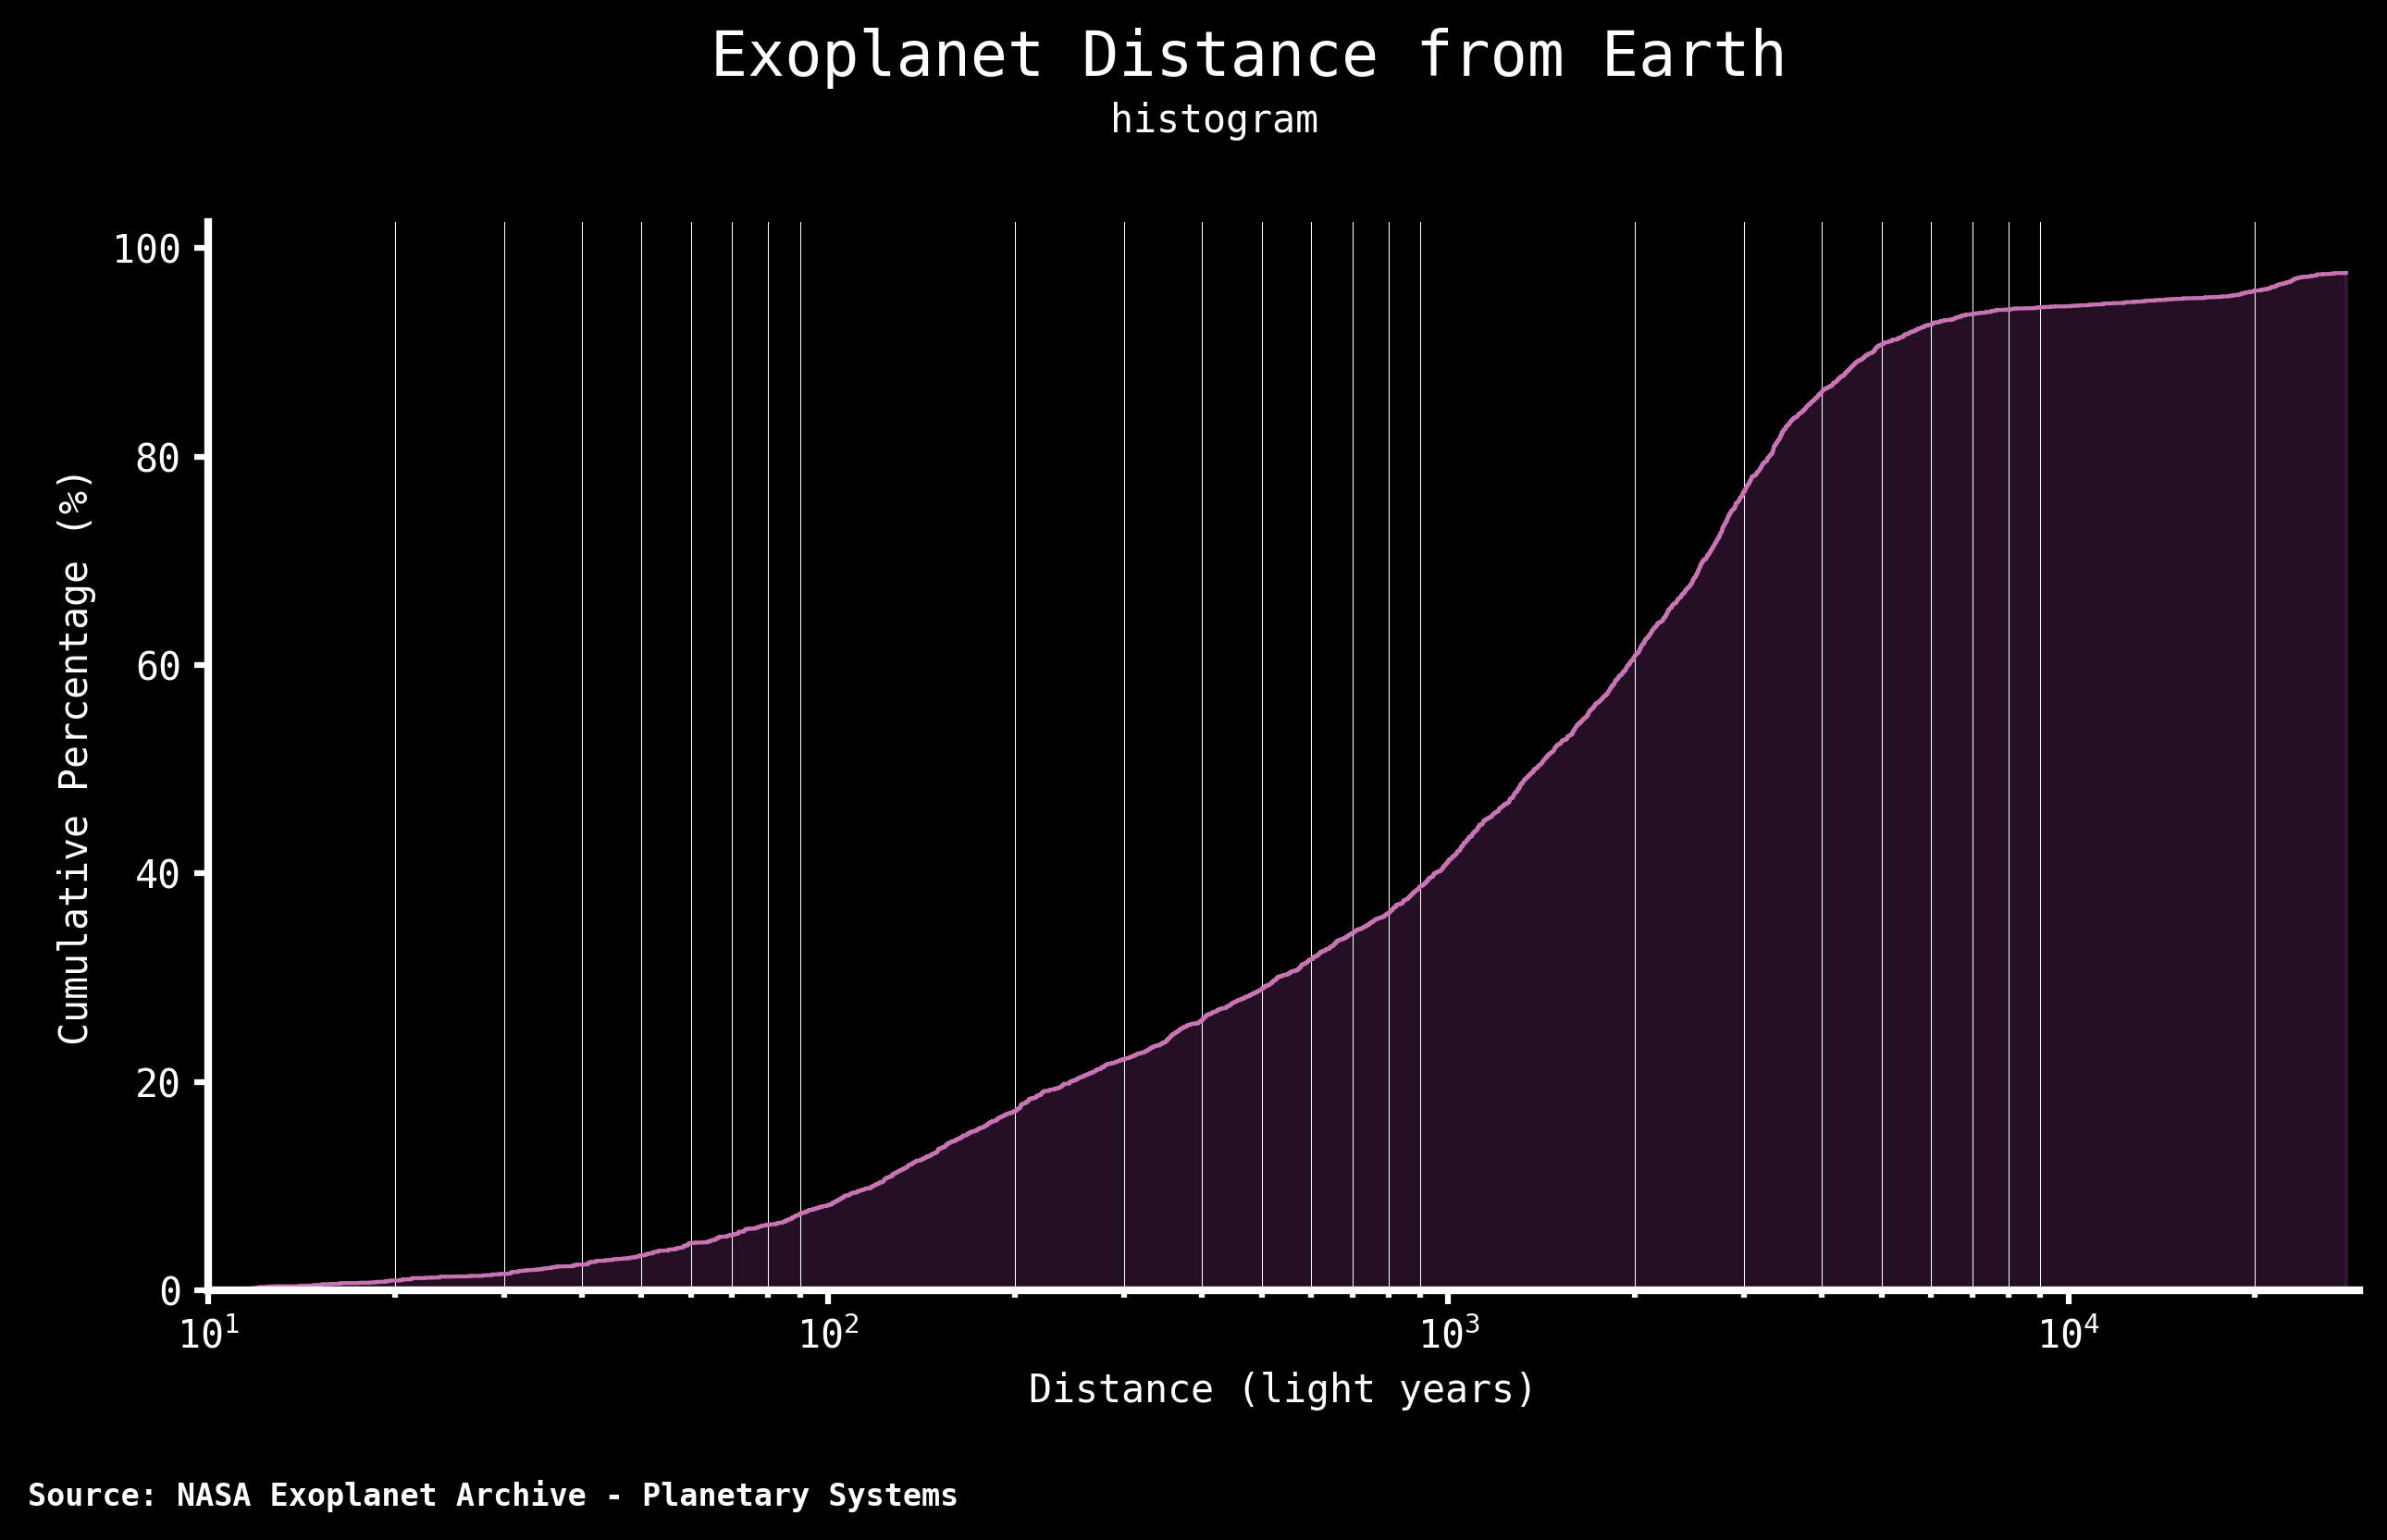

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Figure
fig.dpi = 300
fig.suptitle('Exoplanet Distance from Earth', fontsize=16, y=1.02)
fig.text(0.45, 0.945,"histogram", fontsize=10)

# Computation of cumulative plot
sorted_distances = np.sort(exoplanets['Distance [pc]'] * 3.26)
cumulative_counts = np.arange(1, len(sorted_distances) + 1)
total_exoplanets = len(sorted_distances)
cumulative_percentage = (cumulative_counts / total_exoplanets) * 100
ax.step(sorted_distances, cumulative_percentage, where='post', color=color_palette[3], linestyle='-', linewidth=1)
ax.fill_between(sorted_distances, cumulative_percentage, step='post', color=color_palette[2], alpha=0.3)

fig.text(0.06, -0.05, "Source: NASA Exoplanet Archive - Planetary Systems", ha='left', va='bottom',fontsize=8, fontweight='bold')

# Axis
ax.set_xlabel('Distance (light years)', fontsize=10)
ax.set_xlim(left=10)
ax.set_xscale('log')
ax.set_ylabel('Cumulative Percentage (%)', fontsize=10)
ax.set_ylim(bottom=0)
ax.grid(False, which='minor', linestyle='-', linewidth=0.25, color='w')

# Spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()